## **CycleGAN 실습에 필요한 파이썬 라이브러리를 불러옵니다.** 

In [1]:
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [0]:
import os
os.chdir("/drive/My Drive/Colab Notebooks")

In [0]:
# pyTorch 관련 된 라이브러리.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # optimization에 관한 모듈.
import torchvision # 이미지 관련 전처리, pretrained된 모델, 데이터 로딩에 관한 패키지입니다.
import torchvision.datasets as datasets
import torchvision.transforms as T # 이미지 전처리 모듈입니다.
import torch.utils.data as data
from torch.utils.data import DataLoader

# 기타 필요한 라이브러리.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import time
import datetime
import random
from PIL import Image
from math import log10

### cycleGAN


![구조](https://github.com/yunjey/mnist-svhn-transfer/blob/master/gif/cyclegan.png?raw=true)


구조에 대한 간단한 리뷰

## Training에 사용될 Hyper-parameter를 지정합니다.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # tensor.to(device) 방식을 통해서 cpu -> gpu로 보낼 수 있습니다.
lr = 0.0002 # learning rate 
batch_size = 20 # 한번에 들어갈 배치 수 

## Training에 사용될 데이터를 불러옵니다.
cycleGAN의 경우 두 가지 서로 다른 도메인의 데이터(MNIST, SVHN)가 필요합니다. 모델이 트레이닝 된 이후에는 우리는 MNIST를 SVHN으로 바꾸거나 SVHN 데이터를 MNIST로 바꿀 수 있습니다.

In [0]:
'''
일반적으로 데이터 로딩을 할 때는 transforms를 통해서 일괄적으로 데이터 전처리를 해줍니다.
이 경우 데이터가 서로 다른 사이즈를 가지고 있기 때문에 (32 vs 32), 데이터 사이즈를 맞춰주겠습니다.

'''
transform = T.Compose([
    T.Resize(32), # 32 x 32로 변환
    T.ToTensor()])

In [0]:
# Image를 Load하기 위한 함수입니다.
def load_img(filepath):
    img = Image.open(filepath).convert('RGB') # Image File을 Load합니다.
    img = img.resize((256, 256), Image.BICUBIC) # Image의 크기를 256x256으로 바꿔줍니다.
    return img


"""
MNIST 또는 CIFAR-10과 같이 torchvision 라이브러리에서 제공하지 않는 Dataset의 경우에는 직접 data.Dataset을 상속받아서 만들어야합니다.
이 때, __init__, __getitem__, __len__은 항상 새로 정의해줘야 합니다.
"""
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, file_name):
        super(DatasetFromFolder, self).__init__()
        self.file_name = file_name
        self.a_path = os.path.join(image_dir, file_name) # a는 house 사진
        self.a_filenames = [x for x in os.listdir(self.a_path)] # a 폴더에 있는 파일 목록

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 합니다.
    def __getitem__(self, index):
        # a 폴더에서 사진을 Load합니다.
        a = Image.open(os.path.join(self.a_path, self.a_filenames[index])).convert('RGB')
        
        # a 이미지를 Resize를 하고, Tensor로 바꿔줍니다.
        a = a.resize((286, 286), Image.BICUBIC) #
        a = T.ToTensor()(a) # Quiz
        
        # Data Augmentation
        w_offset = random.randint(0, max(0, 286 - 256 - 1))
        h_offset = random.randint(0, max(0, 286 - 256 - 1))
    
        # a와 b 이미지를 256x256 크기로 Crop을 합니다.(잘라내기)
        a = a[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
    
        a = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)

        if random.random() < 0.5:
            idx = [i for i in range(a.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            a = a.index_select(2, idx)

        return a

    def __len__(self):
        return len(self.a_filenames)

In [0]:
def get_training_set(root_dir, file_name):
    train_dir = os.path.join(root_dir, "train")

    return DatasetFromFolder(train_dir, file_name)


def get_test_set(root_dir, file_name):
    test_dir = os.path.join(root_dir, "test")

    return DatasetFromFolder(test_dir, file_name)

In [8]:
root_dir = "./google-images-download-master/"
os.path.join(root_dir, "test")

'./google-images-download-master/test'

In [0]:
facade_trainset = get_training_set("./google-images-download-master/", "facade")
facade_testset = get_test_set("./google-images-download-master/", "facade")


In [0]:
gaudi_trainset = get_training_set("./google-images-download-master/", "gaudi_facade")
gaudi_testset = get_test_set("./google-images-download-master/", "gaudi_facade")


In [0]:
# Training Set과 Test Set을 각각 DataLoader에 넣습니다.
facade_trainset_loader = DataLoader(dataset=facade_trainset, num_workers=1, batch_size=20, shuffle=True)
gaudi_testset_loader = DataLoader(dataset=gaudi_testset, num_workers=1, batch_size=20, shuffle=True)
facade_testset_loader = DataLoader(dataset=facade_testset, num_workers=1, batch_size=20, shuffle=False)
gaudi_testset_loader = DataLoader(dataset=gaudi_testset, num_workers=1, batch_size=20, shuffle=False)

## 생성자 및 식별자 모델 생성 

In [0]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.05))
    if activation == 'tanh':
        layers.append(nn.Tanh())
    if activation == 'none':
        pass
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.05))
    if activation == 'tanh':
        layers.append(nn.Tanh())
    if activation == 'none':
        pass
                
    return nn.Sequential(*layers)

In [0]:
'''
Generator와 Discriminator를 선언해 줍니다. 
이 때 MNIST는 흑백 이미지이므로 채널이 1이라는 점과 SVHN은 컬러 이미지이므로 채널이 3이라는 것에 주의합니다!!! 
'''

class G(nn.Module):
    """ Generator. """
    def __init__(self, in_dim=3, out_dim=3):
        super(G, self).__init__()
        # encoding blocks
        self.conv1 = conv(in_dim, 64, 4)
        self.conv2 = conv(64, 64*2, 4)
        
        # intermediate blocks
        self.conv3 = conv(64*2, 64*2, 3, 1, 1)
        self.conv4 = conv(64*2, 64*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(64*2, 64, 4)
        self.deconv2 = deconv(64, out_dim, 4, bn=False, activation='tanh')
        
    def forward(self, x):
        out = self.conv1(x)      # (B, 64, 16, 16)
        out = self.conv2(out)    # (B, 128, 8, 8)
        
        out = self.conv3(out)    # (B, 128, 8, 8)
        out = self.conv4(out)    # (B, 128, 8, 8)
        
        out = self.deconv1(out)  # (B, 64, 16, 16)
        out = self.deconv2(out)  # (B, out_dim, 32, 32)
        return out


class D(nn.Module):
    """ Discriminator. """
    def __init__(self, in_dim=3):
        super(D, self).__init__()
        self.conv1 = conv(in_dim, 64, 4, bn=False)
        self.conv2 = conv(64, 64*2, 4)
        self.conv3 = conv(64*2, 64*4, 4)
        self.fc = conv(64*4, 1, 4, 1, 0, bn=False, activation='none')
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)    # (B, 64, 16, 16)
        out = self.conv2(out)  # (B, 128, 8, 8)
        out = self.conv3(out)  # (B, 256, 4, 4)
        out = self.fc(out).squeeze()
        out = self.sigmoid(out)
        return out

## 학습을 위한 사전 모델/optimizer 선언 & 기타준비

In [0]:
# 모델 선언 및 train모드로 만들어 줍니다.
G_hd = G(in_dim=3, out_dim=3).train()
G_dh = G(in_dim=3, out_dim=3).train()
D_h = D(in_dim=3).train()
D_d = D(in_dim=3).train()

# 선언한 모델들을 GPU에서 사용할 수 있도록 해 줍니다.
G_hd = G_hd.to(device)
G_dh = G_dh.to(device)
D_h = D_h.to(device)
D_d = D_d.to(device)

# Optimizer 선언
g_optim = optim.Adam(list(G_hd.parameters()) + list(G_dh.parameters()), lr=lr, betas=(0.5, 0.99))
d_optim = optim.Adam(list(D_h.parameters()) + list(D_d.parameters()), lr=lr, betas=(0.5, 0.99))


In [0]:

# Iteration 수 선언
iters = 10000F

# trainig 과정에서 생성되는 이미지가 어떻게 변화하는지 볼 수 있도록 고정된 데이터를 가지고 있으면 좋습니다.
facade_iter = iter(facade_testset_loader)
gaudi_iter = iter(gaudi_testset_loader)


In [0]:
# 각 도메인별로 2개만 생성해 보겠습니다 
fixed_facade = next(facade_iter)[:2].to(device)
fixed_gaudi = next(gaudi_iter)[:2].to(device)

In [0]:

# Fixed된 이미지를 프린팅하는 함수
def show_images(images):
    print_list = []
    for i in range(2):
        print_list += [images[0][i], images[1][i], images[2][i]]
  
    for i in range(2):
        print_list += [images[3][i], images[4][i], images[5][i]] 
    plt.figure(figsize=(8,14)) # 세로 사이즈 40, 가로 사이즈 20*3
  
    for a in range(1, 7):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])
    for a in range(7, 13):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])      
    plt.show()    

## Training CycleGAN 

여기서의 loss는 크게 4가지로 나누어 집니다.

- D: Real images들을 1로 분류하기 위한 loss (d_real_loss)
- D: Fake images들을 0로 분류하기 위한 loss (d_fake_loss)
- G: D를 속이는 Fake images들을 만들기 위한 loss (D에서 1로 분류함)(g_loss (1))
- G: 다시 돌아 갔을 때 reconstruction을 위한 cycle loss (g_loss (2))

In [0]:
start_time = time.time() # 시간 측정을 위한 변수 

for step in range(iters):
    # 각 도메인의 데이터들을 불러와 줍니다.
    try:
        facade= next(facade_iter) 
        gaudi = next(gaudi_iter)
    except:
        facade_iter = iter(facade_testset_loader)
        gaudi_iter = iter(gaudi_testset_loader)
        facade = next(facade_iter) 
        gaudi = next(gaudi_iter)
    
    # To GPU
    facade = facade.to(device)
    gaudi = gaudi.to(device)
#     s_labels = s_labels.to(device)
    
    #============ train D ============#

    # Real images를 통해 D를 트레이닝 합니다.
    out = D_h(facade)
    d_h_loss = torch.mean((out-1)**2)

    out = D_d(gaudi)
    d_d_loss = torch.mean((out-1)**2)

    d_real_loss = d_h_loss + d_d_loss
  
    d_optim.zero_grad()
    d_real_loss.backward()
    d_optim.step()

    # Fake images = generated images를 통해 D를 트레이닝 합니다.
    fake_gaudi = G_hd(gaudi)
    out = D_d(fake_gaudi)
    d_h_loss = torch.mean(out**2)

    fake_facade = G_dh(gaudi)
    out = D_h(fake_facade)
    d_d_loss = torch.mean(out**2)

    d_fake_loss = d_h_loss + d_d_loss
  
    d_optim.zero_grad()
    d_fake_loss.backward()
    d_optim.step()
  
    '''
    Discriminaor는 이제 한 차례 Real image를 1로 fake image를 0으로 분류하도록 학습했습니다. 
    '''

    #============ train G ============#

    # mnist-svhn-mnist cycle loss를 발생 시킵니다.
    fake_gaudi = G_hd(facade)
    out = D_d(fake_gaudi)
    recon_facade = G_dh(fake_gaudi)
  
    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있습니다. 
    g_loss += torch.mean((facade - recon_facade)**2) # MNIST를 다시 만들어 내야 합니다
  
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()

    # svhn-mnist-svhn loss를 발생 시킵니다.
    fake_facade = G_dh(gaudi)
    out = D_h(fake_facade)
    recon_gaudi = G_hd(fake_facade)

    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있습니다.
    g_loss += torch.mean((gaudi - recon_gaudi)**2) # SVHN를 다시 만들어 내야 합니다

    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()

    # print the log info
    if (step+1) % 1000 == 0:
        # 걸리는 시간 측정 
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))
    
        # fixed image 로 이미지 생성
        facade_to_gaudi = G_hd(fixed_facade)
        recon_facade = G_dh(facade_to_gaudi) 

        gaudi_to_facade = G_dh(fixed_gaudi)
        recon_gaudi = G_hd(gaudi_to_facade)
        
        torch.save(G_hd, "./cycleGAN_facade2gaudi.pckl")
        torch.save(G_dh, "./cycleGAN_gaudi2facade.pckl")
        torch.save(D_d, "./cycleGAN_D_d.pckl")
        torch.save(D_h, "./cycleGAN_D_h.pckl")

        print('======================================================================================================')
        print('Elapsed [%s], Step [%d/%d], d_real_loss: %.4f, d_fake_loss: %.4f, g_loss: %.4f' 
                 % (elapsed, step+1, iters, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
        print('======================================================================================================')
        show_images([fixed_facade.detach().cpu().numpy(), facade_to_gaudi.detach().cpu().numpy(), recon_facade.detach().cpu().numpy()
                        ,fixed_gaudi.detach().cpu().numpy(), gaudi_to_facade.detach().cpu().numpy(), recon_gaudi.detach().cpu().numpy()])

In [0]:
torch.save(G_hd, "./cycleGAN_facade2gaudi.pckl")
torch.save(G_dh, "./cycleGAN_gaudi2facade.pckl")
torch.save(D_d, "./cycleGAN_D_d.pckl")
torch.save(D_h, "./cycleGAN_D_h.pckl")

# # fixed image 로 이미지 생성
# facade_to_gaudi = G_hd(fixed_facade)
# gaudi_recon = G_dh(facade_to_gaudi) 

# gaudi_to_facade = G_dh(fixed_gaudi)
# gaudi_recon = G_hd(gaudi_to_facade)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type G. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.load("./cycleGAN_house2domain.pckl")

In [0]:
G_hd = torch.load("./cycleGAN_house2domain.pckl")
G_dh = torch.load("./cycleGAN_domain2house.pckl")

In [0]:
# trainig 과정에서 생성되는 이미지가 어떻게 변화하는지 볼 수 있도록 고정된 데이터를 가지고 있으면 좋습니다.
house_iter = iter(house_testset_loader)
domain_iter = iter(domain_testset_loader)


In [0]:
fixed_facade = next(facade_iter)[8:10].to(device)
fixed_gaudi = next(gaudi_iter)[8:10].to(device)

In [0]:
house_to_domain = G_hd(fixed_house)
recon_house = G_dh(house_to_domain) 

domain_to_house = G_dh(fixed_domain)
recon_domain = G_hd(domain_to_house)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

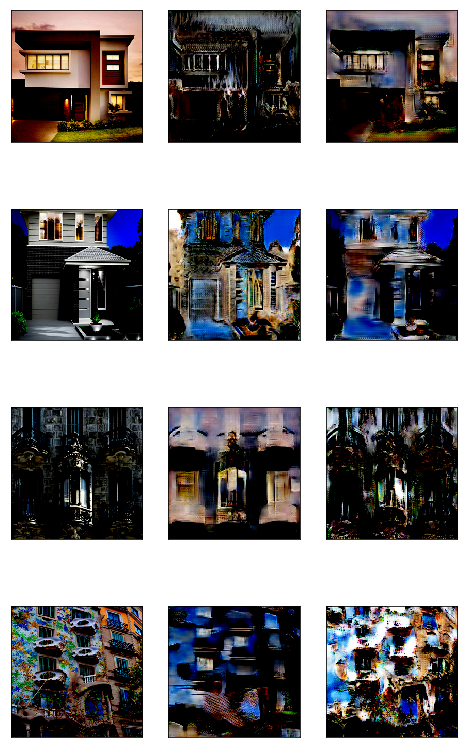

In [0]:
show_images([fixed_house.detach().cpu().numpy(), house_to_domain.detach().cpu().numpy(), recon_house.detach().cpu().numpy()
                        ,fixed_domain.detach().cpu().numpy(), domain_to_house.detach().cpu().numpy(), recon_domain.detach().cpu().numpy()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

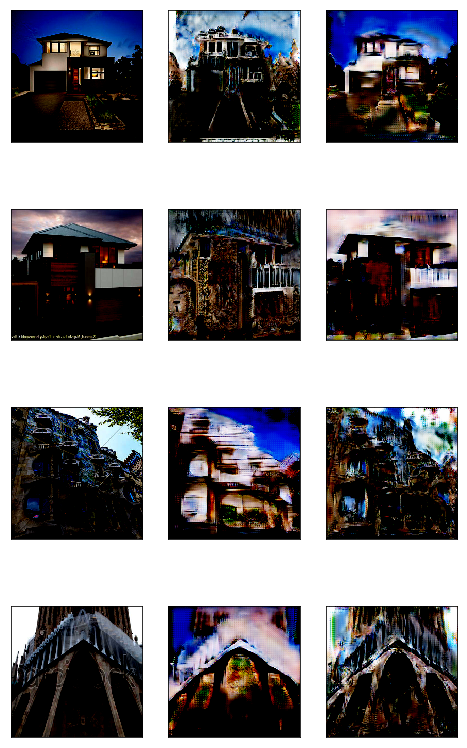

In [0]:
show_images([fixed_house.detach().cpu().numpy(), house_to_domain.detach().cpu().numpy(), recon_house.detach().cpu().numpy()
                        ,fixed_domain.detach().cpu().numpy(), domain_to_house.detach().cpu().numpy(), recon_domain.detach().cpu().numpy()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

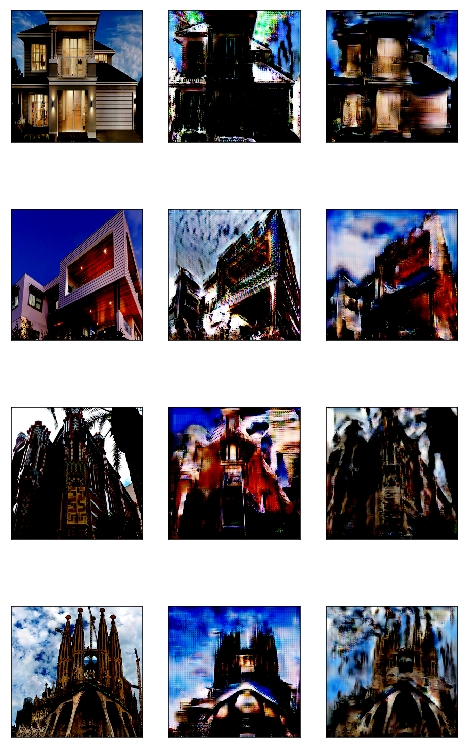

In [0]:
show_images([fixed_house.detach().cpu().numpy(), house_to_domain.detach().cpu().numpy(), recon_house.detach().cpu().numpy()
                        ,fixed_domain.detach().cpu().numpy(), domain_to_house.detach().cpu().numpy(), recon_domain.detach().cpu().numpy()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

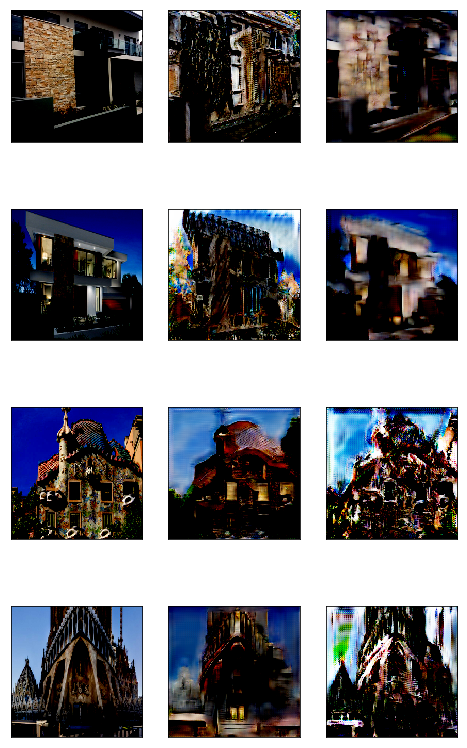

In [0]:
show_images([fixed_house.detach().cpu().numpy(), house_to_domain.detach().cpu().numpy(), recon_house.detach().cpu().numpy()
                        ,fixed_domain.detach().cpu().numpy(), domain_to_house.detach().cpu().numpy(), recon_domain.detach().cpu().numpy()])